In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys() :
  print('User Uploaded file "{name}" with length {length} bytes'.format(name = fn, length= len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d wenewone/cub2002011

Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011
License(s): CC0-1.0
 99% 1.48G/1.49G [00:08<00:00, 151MB/s]
100% 1.49G/1.49G [00:08<00:00, 194MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/cub2002011.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [9]:
# Dataset class dengan dataframe
class CUBDatasetWithDataFrame(Dataset):
    def __init__(self, dataframe, transform=None, is_training=True):
        self.dataframe = dataframe
        self.transform = transform

        if is_training:
            self.data = dataframe[dataframe['is_training'] == 1].reset_index(drop=True)
        else:
            self.data = dataframe[dataframe['is_training'] == 0].reset_index(drop=True)

        self.classes = sorted(self.data['class_name'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

    def get_class_weights(self):
        class_counts = self.data['class_name'].value_counts()
        total_samples = len(self.data)
        num_classes = len(self.classes)

        class_weights = {}
        for class_name, count in class_counts.items():
            class_weights[self.class_to_idx[class_name]] = total_samples / (num_classes * count)

        weights = [class_weights[i] for i in range(len(self.classes))]
        return torch.tensor(weights, dtype=torch.float32)

    def create_sampler(self):
        sample_weights = []
        for idx in range(len(self.data)):
            class_name = self.data.iloc[idx]['class_name']
            class_idx = self.class_to_idx[class_name]
            weight = 1.0 / self.data['class_name'].value_counts()[class_name]
            sample_weights.append(weight)

        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        return sampler

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['full_path']
        class_name = self.data.iloc[idx]['class_name']
        label = self.class_to_idx[class_name]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print("Error loading image", img_path, e)
            image = Image.new('RGB', (224, 224), color='red')

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Function untuk membuat dataframe dari CUB-200-2011
def create_cub_dataframe(root_dir):
    base_path = os.path.join(root_dir, 'CUB_200_2011')
    images_path = os.path.join(base_path, 'images')

    images_file = os.path.join(base_path, 'images.txt')
    images_df = pd.read_csv(images_file, sep=' ', header=None, names=['image_id', 'image_path'])

    split_file = os.path.join(base_path, 'train_test_split.txt')
    split_df = pd.read_csv(split_file, sep=' ', header=None, names=['image_id', 'is_training'])

    classes_file = os.path.join(base_path, 'classes.txt')
    classes_df = pd.read_csv(classes_file, sep=' ', header=None, names=['class_id', 'class_name'])

    labels_file = os.path.join(base_path, 'image_class_labels.txt')
    labels_df = pd.read_csv(labels_file, sep=' ', header=None, names=['image_id', 'class_id'])

    merged_df = images_df.merge(split_df, on='image_id')
    merged_df = merged_df.merge(labels_df, on='image_id')
    merged_df = merged_df.merge(classes_df, on='class_id')

    merged_df['full_path'] = merged_df['image_path'].apply(lambda x: os.path.join(images_path, x))
    merged_df['class_idx'] = merged_df['class_id'] - 1

    print("DataFrame created with", len(merged_df), "images")
    print("Training images:", len(merged_df[merged_df['is_training'] == 1]))
    print("Test images:", len(merged_df[merged_df['is_training'] == 0]))
    print("Number of classes:", len(merged_df['class_name'].unique()))

    return merged_df, classes_df

In [11]:
# Create dataframe
print("Creating CUB-200-2011 DataFrame...")
cub_df, classes_df = create_cub_dataframe('/content')

Creating CUB-200-2011 DataFrame...
DataFrame created with 11788 images
Training images: 5994
Test images: 5794
Number of classes: 200


In [13]:
# Create datasets
train_dataset = CUBDatasetWithDataFrame(cub_df, transform=train_transform, is_training=True)
test_dataset = CUBDatasetWithDataFrame(cub_df, transform=val_transform, is_training=False)

print("Train dataset:", len(train_dataset), "images,", len(train_dataset.classes), "classes")
print("Test dataset:", len(test_dataset), "images,", len(test_dataset.classes), "classes")

Train dataset: 5994 images, 200 classes
Test dataset: 5794 images, 200 classes


In [14]:
# Get class weights for balanced loss
class_weights = train_dataset.get_class_weights().to(device)
print("Class weights range:", class_weights.min().item(), "-", class_weights.max().item())


Class weights range: 0.9990000128746033 - 1.0334482192993164


In [15]:
# Create data loaders dengan balancing
batch_size = 32
train_sampler = train_dataset.create_sampler()
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

Train batches: 188
Test batches: 182


In [16]:
# Model 1: ResNet tanpa Transfer Learning
class ResNetFromScratch(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFromScratch, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [17]:
# Model 2: ResNet dengan Feature Extraction (Pre-trained)
class ResNetFeatureExtraction(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFeatureExtraction, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [18]:
# Model 3: ResNet dengan Fine-Tuning
class ResNetFineTuning(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFineTuning, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [19]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, model_name="Model"):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print("Training", model_name)
    print("Using", len(train_dataset), "training images across", len(train_dataset.classes), "classes")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies


In [20]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [22]:
# Main execution
num_epochs = 10
num_classes = 200
results = {}

# Balanced loss function
criterion_balanced = nn.CrossEntropyLoss(weight=class_weights)

In [23]:
# 1. ResNet Tanpa Transfer Learning)
print("1. TRAINING RESNET TANPA TRANSFER LEARNING")
model1 = ResNetFromScratch(num_classes).to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
train_losses1, train_accs1, test_accs1 = train_model(
    model1, train_loader, test_loader, criterion_balanced, optimizer1,
    num_epochs, "ResNet From Scratch"
)
results["From Scratch"] = (train_losses1, train_accs1, test_accs1)

1. TRAINING RESNET TANPA TRANSFER LEARNING
Training ResNet From Scratch
Using 5994 training images across 200 classes


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 5.4003, Train Acc: 0.80%, Test Acc: 0.95%
Epoch [2/10], Loss: 5.1978, Train Acc: 1.02%, Test Acc: 1.05%
Epoch [3/10], Loss: 5.1120, Train Acc: 1.99%, Test Acc: 1.76%
Epoch [4/10], Loss: 5.0302, Train Acc: 1.99%, Test Acc: 2.52%
Epoch [5/10], Loss: 4.9002, Train Acc: 2.60%, Test Acc: 2.88%
Epoch [6/10], Loss: 4.7879, Train Acc: 3.05%, Test Acc: 3.12%
Epoch [7/10], Loss: 4.6529, Train Acc: 4.19%, Test Acc: 4.06%
Epoch [8/10], Loss: 4.5386, Train Acc: 4.50%, Test Acc: 4.44%
Epoch [9/10], Loss: 4.4383, Train Acc: 5.17%, Test Acc: 4.59%
Epoch [10/10], Loss: 4.3802, Train Acc: 6.47%, Test Acc: 6.75%


In [24]:
# 2. ResNet dengan Feature Extraction (Pre-trained)
print("2. TRAINING RESNET DENGAN FEATURE EXTRACTION")
model2 = ResNetFeatureExtraction(num_classes).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
train_losses2, train_accs2, test_accs2 = train_model(
    model2, train_loader, test_loader, criterion_balanced, optimizer2,
    num_epochs, "Feature Extraction"
)
results["Feature Extraction"] = (train_losses2, train_accs2, test_accs2)

2. TRAINING RESNET DENGAN FEATURE EXTRACTION
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Training Feature Extraction
Using 5994 training images across 200 classes
Epoch [1/10], Loss: 4.7711, Train Acc: 8.34%, Test Acc: 16.41%
Epoch [2/10], Loss: 3.5209, Train Acc: 25.91%, Test Acc: 26.98%
Epoch [3/10], Loss: 2.9162, Train Acc: 35.99%, Test Acc: 34.05%
Epoch [4/10], Loss: 2.5474, Train Acc: 43.59%, Test Acc: 37.52%
Epoch [5/10], Loss: 2.3447, Train Acc: 46.53%, Test Acc: 40.13%
Epoch [6/10], Loss: 2.1068, Train Acc: 50.92%, Test Acc: 40.21%
Epoch [7/10], Loss: 2.0148, Train Acc: 51.75%, Test Acc: 41.15%
Epoch [8/10], Loss: 1.9137, Train Acc: 54.44%, Test Acc: 42.79%
Epoch [9/10], Loss: 1.8225, Train Acc: 55.76%, Test Acc: 43.01%
Epoch [10/10], Loss: 1.7089, Train Acc: 58.12%, Test Acc: 43.17%


In [25]:
# 3. ResNet dengan Fine-Tuning
print("3. TRAINING RESNET DENGAN FINE-TUNING")
model3 = ResNetFineTuning(num_classes).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001, weight_decay=1e-4)
train_losses3, train_accs3, test_accs3 = train_model(
    model3, train_loader, test_loader, criterion_balanced, optimizer3,
    num_epochs, "Fine-Tuning"
)
results["Fine-Tuning"] = (train_losses3, train_accs3, test_accs3)


3. TRAINING RESNET DENGAN FINE-TUNING
Training Fine-Tuning
Using 5994 training images across 200 classes
Epoch [1/10], Loss: 4.5456, Train Acc: 13.55%, Test Acc: 22.32%
Epoch [2/10], Loss: 3.1840, Train Acc: 39.72%, Test Acc: 38.73%
Epoch [3/10], Loss: 2.3165, Train Acc: 57.27%, Test Acc: 49.38%
Epoch [4/10], Loss: 1.7647, Train Acc: 68.00%, Test Acc: 57.01%
Epoch [5/10], Loss: 1.3481, Train Acc: 76.98%, Test Acc: 59.91%
Epoch [6/10], Loss: 1.0709, Train Acc: 81.41%, Test Acc: 62.17%
Epoch [7/10], Loss: 0.8398, Train Acc: 85.40%, Test Acc: 63.77%
Epoch [8/10], Loss: 0.6912, Train Acc: 88.22%, Test Acc: 63.26%
Epoch [9/10], Loss: 0.5719, Train Acc: 90.62%, Test Acc: 65.64%
Epoch [10/10], Loss: 0.4679, Train Acc: 92.28%, Test Acc: 65.36%


In [27]:
# Results comparison
print("FINAL RESULTS COMPARISON")
final_results = []
for method_name, (train_losses, train_accs, test_accs) in results.items():
    final_train_acc = train_accs[-1]
    final_test_acc = test_accs[-1]
    best_test_acc = max(test_accs)

    final_results.append({
        'Method': method_name,
        'Final Train Accuracy': final_train_acc,
        'Final Test Accuracy': final_test_acc,
        'Best Test Accuracy': best_test_acc,
        'Epochs to Best': test_accs.index(best_test_acc) + 1
    })

results_df = pd.DataFrame(final_results)
print("FINAL COMPARISON:")
print(results_df.to_string(index=False))

FINAL RESULTS COMPARISON
FINAL COMPARISON:
            Method  Final Train Accuracy  Final Test Accuracy  Best Test Accuracy  Epochs to Best
      From Scratch              6.473140             6.748360            6.748360              10
Feature Extraction             58.124791            43.165343           43.165343              10
       Fine-Tuning             92.275609            65.360718           65.636866               9


/tmp/ipython-input-3834998123.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Best Test Accuracy', data=results_df, ax=ax4, palette='viridis')


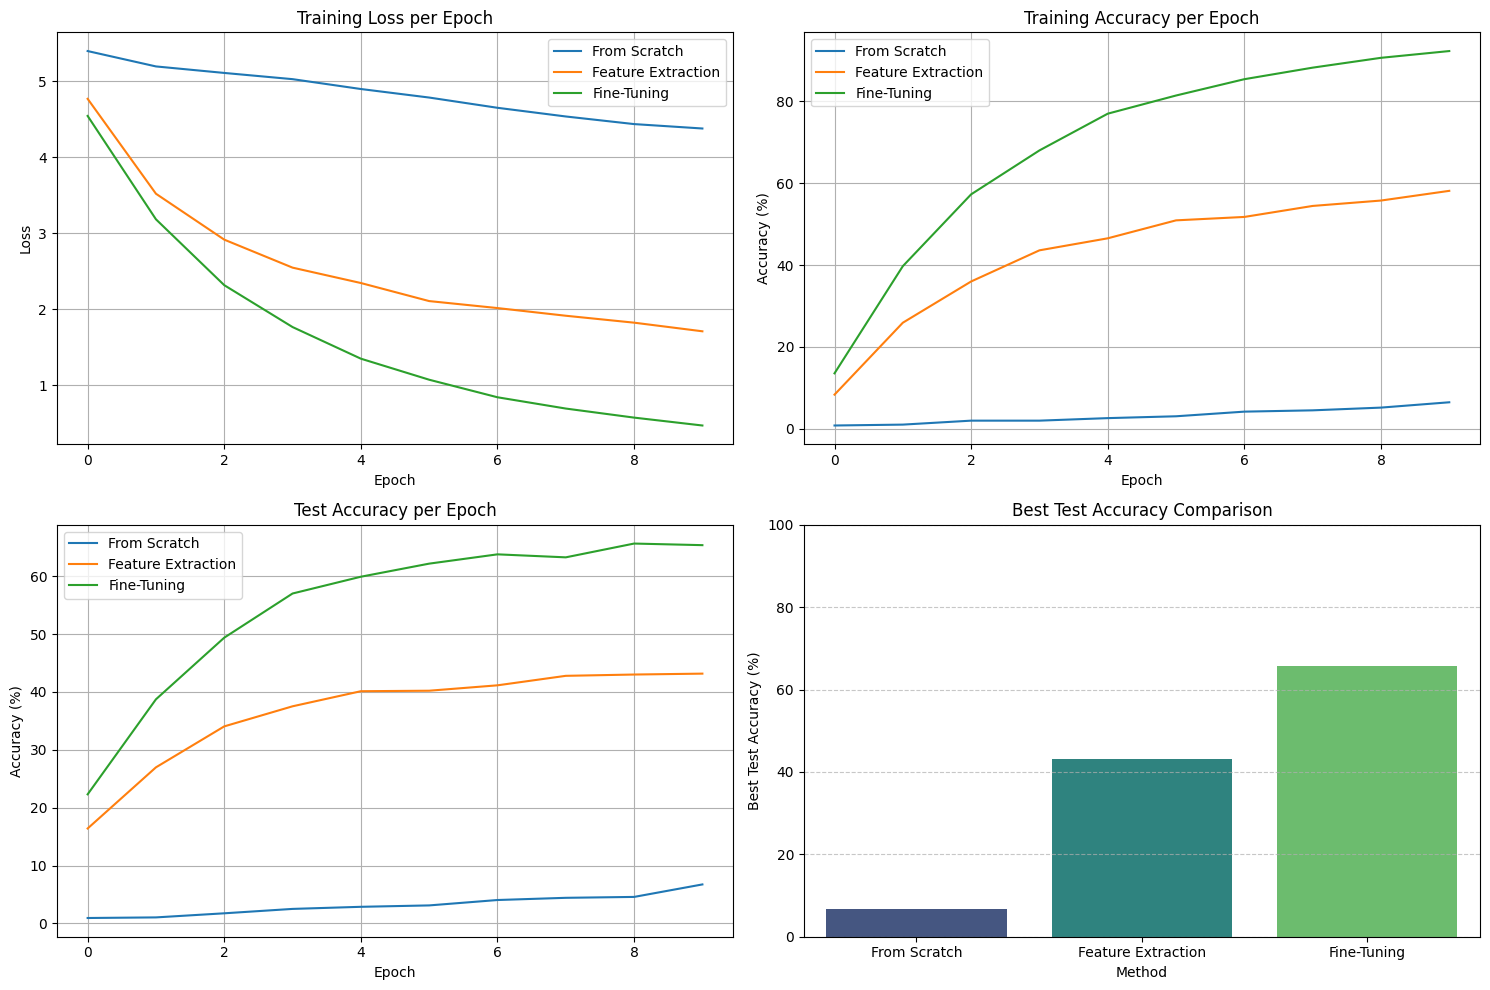

In [31]:
# Plot results
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot Training Loss
for method_name, (train_losses, train_accs, test_accs) in results.items():
    ax1.plot(train_losses, label=method_name)
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Training Accuracy
for method_name, (train_losses, train_accs, test_accs) in results.items():
    ax2.plot(train_accs, label=method_name)
ax2.set_title('Training Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Plot Test Accuracy
for method_name, (train_losses, train_accs, test_accs) in results.items():
    ax3.plot(test_accs, label=method_name)
ax3.set_title('Test Accuracy per Epoch')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.grid(True)

# Plot Best Test Accuracy Comparison
sns.barplot(x='Method', y='Best Test Accuracy', data=results_df, ax=ax4, palette='viridis')
ax4.set_title('Best Test Accuracy Comparison')
ax4.set_xlabel('Method')
ax4.set_ylabel('Best Test Accuracy (%)')
ax4.set_ylim(0, 100) # Set y-axis limit to 0-100 for accuracy
ax4.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()